# Rede Neural Artificial - Regressão Linear Simples

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

%matplotlib inline

## Obter os dados

In [2]:
data = pd.read_csv("autos.csv", encoding="ISO-8859-1")

In [3]:
# dateCrawled - data de quando os dados foram obtidos (não tem influencia no preço a prever).
# oferta - Angebot significa oferta em alemão.
# price - variavel a prever.
# monthOfRegistration - pode não ser utilizado para prever o preço.
# fuelType - benzin significa gasolina e andere outro tipo de combustisvel.
# dateCreated - data de quando os registros foram inseridos na base de dados (não tem influencia no preço).
# nrOfPictures - numero de fotos no website (não tem influencia no preço do veiculo).
# postalCode - localização do veiculo (pode ter influencia no preço do veiculo).
# lastSeen - ultima vez que o anuncio foi visto (não tem influencia no preço).

data.head(2)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


## Pré-Processamento: Remover colunas que não têm influência no modelo

In [4]:
# Existe uma grande variedade nos nomes dos carros registrados, o que pode complicar a previsão.
# Optou-se por remover esta coluna para não complicar o modelo. Mas mantem-se a coluna com o modelo e a coluna com a marca,
# que contêm a mesma informação.

data["name"].value_counts(ascending=True)[:4]

Audi_A3_Diesel_2.0_top_Zustand_oder_umtauschen_gegen_Audi4:Audi6    1
CLS500_/AMG_/_EXCLUSIV__LEDER__Alpakagrau_42.800                   1
Peugeot_806_2L_HDI                                                  1
Bmw_E36_323i_No_328_325_320_318is_316_M3_M5                         1
Name: name, dtype: int64

In [5]:
# Existem 206644 registros só com 1 nome.
sum(data["name"].value_counts()==1)

206644

In [6]:
# Existem apenas 26887 registros com mais de 1 nome.
sum(data["name"].value_counts()>1)

26887

In [7]:
# Só exitem 3 registros de vendedores comerciais (gewerblich). Como quase todos os vendedores são privados o algoritmo não irá
# conseguir modelar a inflência dos vendedores comerciais no preço dos carros. Então esta variavel não tem influência no modelo.
data["seller"].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

In [8]:
# Só exitem 12 registros de vendas por leilão (gsuch). Como quase todas as vendas são por oferta o algoritmo não irá
# conseguir modelar a inflência das vendas por leilão no preço dos carros. Então esta variavel não tem influência no modelo.
data["offerType"].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

In [9]:
data = data.drop(["dateCrawled", "dateCreated", "nrOfPictures", "postalCode", "lastSeen", "name", "seller", "offerType"], axis=1)

In [10]:
data.head(2)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja


## Pré-Processamento: Tratamento de Valores Inconsistentes

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 12 columns):
price                  371528 non-null int64
abtest                 371528 non-null object
vehicleType            333659 non-null object
yearOfRegistration     371528 non-null int64
gearbox                351319 non-null object
powerPS                371528 non-null int64
model                  351044 non-null object
kilometer              371528 non-null int64
monthOfRegistration    371528 non-null int64
fuelType               338142 non-null object
brand                  371528 non-null object
notRepairedDamage      299468 non-null object
dtypes: int64(5), object(7)
memory usage: 34.0+ MB


In [12]:
# Quantidade de carros com preço inferior a 10 euros
data[data["price"] <= 10]["price"].value_counts()

0     10778
1      1189
10       84
5        26
2        12
8         9
3         8
9         8
7         3
4         1
Name: price, dtype: int64

In [13]:
# Existem 12118 registros de carros com um preço inferior a 10 euros
len(data[data["price"] <= 10]["price"])

12118

In [14]:
# Quantidade de carros com preço inferior a 10 euros
data[data["price"] >= 350000]["price"].value_counts().head()

99999999    15
999999      13
11111111    10
12345678     9
10000000     8
Name: price, dtype: int64

In [15]:
# Existem 115 registros de carros com um preço superior a 350000 euros
len(data[data["price"] >= 350000]["price"])

119

In [16]:
# Optou-se por apagar os registros. Como são muitos registros se o valor do preço fosse substituido pelo seu valor médio poderia
# ter influência no desvio padrão do modelo(que diminuiria).

data = data[(data["price"]>10) & (data["price"]<350000)]

In [17]:
# 359291 = 371528 - 12118 - 119
len(data)

359291

In [18]:
# teste para ver se o novo dataframe não contem os valores inconsistentes
data[data["price"] >= 350000]["price"].value_counts()

Series([], Name: price, dtype: int64)

In [19]:
# teste para ver se o novo dataframe não contem os valores inconsistentes
data[data["price"] <= 10]["price"].value_counts()

Series([], Name: price, dtype: int64)

## Pré-Processamento: Tratamento de Valores Ausentes

In [20]:
# Soma dos valores nulos por coluna
data.isnull().sum()

price                      0
abtest                     0
vehicleType            33546
yearOfRegistration         0
gearbox                17236
powerPS                    0
model                  17967
kilometer                  0
monthOfRegistration        0
fuelType               29391
brand                      0
notRepairedDamage      65986
dtype: int64

In [21]:
# percentagem dos valores nulos por coluna
percent = (data.isnull().sum()/len(data))*100
sorted(percent, reverse=True)[:10]

[18.365614501894008,
 9.336721487596405,
 8.180277268286709,
 5.000681898516801,
 4.797225647177358,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

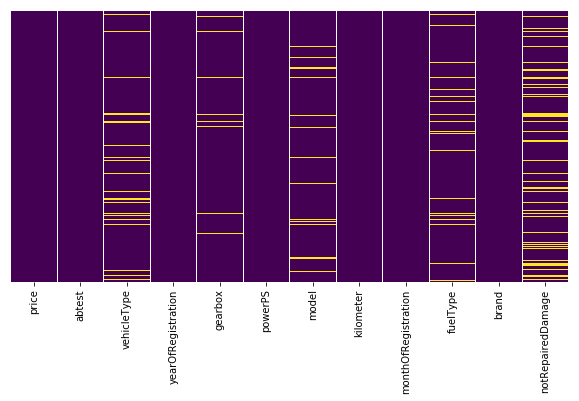

In [22]:
# Visualização dos valores nulos
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [23]:
# Nas variaveis categoricas vai-se substituir os valores ausentes pelo valor que mais vezes se repete.
# Tambem se poderia apagar as linhas que têm valores ausentes, quando estas representam uma percentagem pequena dos valores
# totais.

In [24]:
# limousine é o valor que mais vezes se repete na coluna vehicleType.
data["vehicleType"].value_counts().head(2)

limousine     93614
kleinwagen    78014
Name: vehicleType, dtype: int64

In [25]:
# manuell é o valor que mais vezes se repete na coluna gearbox.
data["gearbox"].value_counts().head(2)

manuell      266547
automatik     75508
Name: gearbox, dtype: int64

In [26]:
# golf é o valor que mais vezes se repete na coluna model.
data["model"].value_counts().head(2)

golf      28989
andere    25560
Name: model, dtype: int64

In [27]:
# benzin é o valor que mais vezes se repete na coluna fuelType.
data["fuelType"].value_counts().head(2)

benzin    217582
diesel    106002
Name: fuelType, dtype: int64

In [28]:
# nein é o valor que mais vezes se repete na coluna notRepairedDamage
data["notRepairedDamage"].value_counts().head(2)

nein    259301
ja       34004
Name: notRepairedDamage, dtype: int64

In [29]:
# Dicionario com os valores a preencher em substituição dos NaN.
valores = {"vehicleType":"limousine", "gearbox":"manuell", "model":"golf", "fuelType":"benzin", "notRepairedDamage":"nein"}

In [30]:
# Substituição dos valores ausentes
data = data.fillna(value=valores)

In [31]:
# Congirmação de que já não existem valores ausentes.
data.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [32]:
data["vehicleType"].value_counts()

limousine     127160
kleinwagen     78014
kombi          65921
bus            29699
cabrio         22509
coupe          18386
suv            14477
andere          3125
Name: vehicleType, dtype: int64

## Pré-processamento - label encoder (Transformação de variaveis categóricas em quantitativas)

In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
enc = LabelEncoder()

In [35]:
# Transformar as variáveis categoricas em numéricas para que a rede neural as compreenda. As redes neurais só trabalham com
# dados númericos.
data["abtest"] = enc.fit_transform(data["abtest"])
data["vehicleType"] = enc.fit_transform(data["vehicleType"])
data["gearbox"] = enc.fit_transform(data["gearbox"])
data["model"] = enc.fit_transform(data["model"])
data["fuelType"] = enc.fit_transform(data["fuelType"])
data["brand"] = enc.fit_transform(data["brand"])
data["notRepairedDamage"] = enc.fit_transform(data["notRepairedDamage"])

## Pré-processamento - one hot encoder

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [37]:
data["vehicleType"].value_counts()

6    127160
4     78014
5     65921
1     29699
2     22509
3     18386
7     14477
0      3125
Name: vehicleType, dtype: int64

In [38]:
# https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
# https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

# https://www.quora.com/Minmaxscaler-vs-Standardscaler-Are-there-any-specific-rules-to-use-one-over-the-other-for-a-particular-application
# https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer
# https://jovianlin.io/feature-scaling/

# Ao se utilizar apenas o labelencoder o algoritmo assume que quanto maior for o valor, melhor é a categoria. Assume que existe
# uma ordenação(7 melhor do que 6) dos valores da categoria.

# Por exemplo na coluna vehicleType o algoritmo assumiria que o vehicleType 6(limousine) seria melhor que o vehicleType 1(bus).
# Se o algoritmo calcular a média entre o vehicleType 6 e vehicleType 0  (6+0)/2=3. A média  seria o vehicleType 3(coupe). 
# O que não faz sentido. Por isso deve-se utilizar o one-hot-encoding para transformar a coluna inicial em variáveis(colunas) 
# binárias. Tambem se pode utilizar o pd.get_dummies()

# vehicleType 0: 1 0 0 0 0 0 0
# vehicleType 1: 0 1 0 0 0 0 0
# ....
# vehicleType 6: 0 0 0 0 0 1 0
# vehicleType 7: 0 0 0 0 0 0 1

In [39]:
data.head(2)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,1,6,1993,1,0,118,150000,0,1,38,1
1,18300,1,3,2011,1,190,118,125000,5,3,1,0


In [40]:
# data["abtest"] = data[:,1]
# data["vehicleType"] = data[:,2]
# data["gearbox"] = data[:,4]
# data["model"] = data[:,6]
# data["fuelType"] = data[:,9]
# data["brand"] = data[:,10]
# data["notRepairedDamage"] = data[:,11]

# No OneHotEncoder()
# O categories é utilizado quando se deseja passar manualmente o nome das categorias, por sua vez, no categorical_features é 
# passado um array de índices.

# Variaveis a transformar em dummies
# remainder: manter as colunas que não são transformadas
# oneHotEncoder: transformar as varieveis em dummies
# colunas a transformar: [1,2,4,6,9,10,11]
transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [1,2,4,6,9,10,11])], remainder='passthrough')

In [41]:
data = transformer.fit_transform(data).toarray()

C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [42]:
data = pd.DataFrame(data)

In [43]:
# Novo dataframe com as variaveis dummies
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,307,308,309,310,311,312,313,314,315,316
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,480.0,1993.0,0.0,150000.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,18300.0,2011.0,190.0,125000.0,5.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,9800.0,2004.0,163.0,125000.0,8.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1500.0,2001.0,75.0,150000.0,6.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3600.0,2008.0,69.0,90000.0,7.0


In [44]:
# Preço dos carros. Variavel a prever.
data[312].head()

0      480.0
1    18300.0
2     9800.0
3     1500.0
4     3600.0
Name: 312, dtype: float64

## Divisão Treino-Teste 

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# X - variáveis usadas para modelar o modelo
X = data.drop(312, axis=1)
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,306,307,308,309,310,311,313,314,315,316
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1993.0,0.0,150000.0,0.0


In [47]:
# y - variavel que se pretende avaliar
y = data[312]
y.head(1)

0    480.0
Name: 312, dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

KeyboardInterrupt: 

## Modelo Artificial Neural Network

In [53]:
# Deveria ser feito a normalização das variaveis porque existem variaveis dominantes.

In [54]:
# sequential - uma cada apos a outra
# dense - camadas fully conected, cada neuronio esta conectado a todos os neuronios da camada seguinte

# 1ª Camada Oculta(e definição da camada de entrada) 
# Neuronios: normalmente escolhe-se o número de neuronios igual ao número de variaveis de entrada mais o número de variaveis de 
# saida divididos por 2 ((316+1)/2=158) para começar a modelar a rede. 
# Função de Activação: Normalmente escolhe-se a reLu para deep learning porque obtem-se melhores resultados do que com uma
# função sigmoide ou tangente hiperbolica. 
# input_dim: quantos atributos existem na camada de entrada (neste caso são 316 variaveis de entrada). Este parâmetro só é 
# necessário para a primeira camada oculta.

# 2ª Camada Oculta
# Na segunda camada oculta em geral coloca-se a mesma quantidade de neurónios do que na primeira.

# Camada de Saida
# Neuronios: Igual ao número de saidas possiveis. Para regressão simples é 1 (Só se quer prever o preço do veiculo).
# Função de activação: linear é a função utilizada para problemas de regressão simples. Não faz nenhuma operação adicional.
# Apenas tem em conta a multiplicação dos dados de entrada pelos pesos e aplicação da função relu à função soma e retorna o
# valor da função soma. (Ao contrario da função sigmoid e softmax que transformam o resultado da função soma em probabilidade).

model = models.Sequential()
model.add(layers.Dense(units=158, activation="relu", input_dim=316))
model.add(layers.Dense(units=158, activation="relu"))
model.add(layers.Dense(units=1, activation="linear"))

In [55]:
# Optimizer: adam é uma optimização da descida do gradiente estócastico (usado para encontrar os melhores valores dos pesos).
# É o que melhor se adapta à maioria dos casos.

# loss: função de perda mean_absolute_error é utilizada para problemas de regressão. Clacula o erro absoluto entre o valor 
# previsto e o valor real (|valor real-valor previsto|).

model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_absolute_error"])

In [58]:
# batch_size: 300, calcula-se o erro de um conjunto de 300 dados e actualizam-se todos os pesos. Quanto mais alto este valor, 
# mais rapido são executados os calculos.

# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente
# Nº total de dados: 359291
# Nº total de dados de treino: 0,25x359291 = 269468.

# 1ª epoca- calcula o erro para os primeiros 300 dados e actualiza todos os pesos. calcula o o erro para os 300 dados seguintes 
# e actualiza todos os pesos. E assim sucessivamente.
# 2ª epoca- calcula o erro para os primeiros 300 dados(com os pesos da 1ª epoca) e actualiza todoss os pesos. calcula o o erro 
# para os 300 dados seguintes(com os pesos da 1ª epoca) e actualiza todos os pesos. E assim sucessivamente.

# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, y_train, batch_size=300, epochs=5)

Train on 269468 samples
Epoch 1/5
269468/269468 [==============================] - 594s 2ms/sample - loss: 2984.2476 - mean_absolute_error: 2984.2466
Epoch 2/5
269468/269468 [==============================] - 4s 16us/sample - loss: 2931.6990 - mean_absolute_error: 2931.6968
Epoch 3/5
269468/269468 [==============================] - 5s 17us/sample - loss: 2842.8081 - mean_absolute_error: 2842.8052
Epoch 4/5
269468/269468 [==============================] - 5s 17us/sample - loss: 2807.8057 - mean_absolute_error: 2807.8071
Epoch 5/5
269468/269468 [==============================] - 5s 17us/sample - loss: 2777.5331 - mean_absolute_error: 2777.5320


## Previsão e Avaliação do Modelo ANN

In [59]:
from sklearn import metrics

In [91]:
# Prever os dados de teste para avaliar o modelo
predictions = model.predict(X_test)

In [3]:
# Transformar o array predictions para uma dimensão
predictions = predictions.flatten()
predictions

NameError: name 'predictions' is not defined

In [4]:
# Dataframe com a comparação entre os dados de teste e os dados previstos
df = pd.DataFrame({"y_teste":np.array(y_test), "predictions":predictions})
df.head()

NameError: name 'pd' is not defined

### Avaliação do Modelo

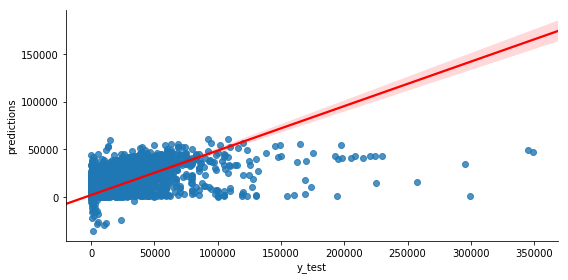

In [140]:
# Gráfico de regressão linear com a comparação entre os dados de treino e os dados de teste

#Não se assemelha-se a uma linha recta (preço previsto = preço real(de teste))
#O preço do carro não tem valores negativos, está entre 10 e 350000 euros.

sns.lmplot(x="y_test", y="predictions", data=df, line_kws={'color': 'red'}, height=4, aspect=2)

In [100]:
# Existem valores negativos para a previsão dos preços dos carros. 
predictions.min()

-35395.867

In [146]:
# Média do preço previsto dos carros com os dados de entrada de teste
predictions.mean()

4830.9224

In [147]:
# Média do real preço dos carros nos dados de teste
y_test.mean()

5887.573472273249

In [101]:
# Avaliação do modelo
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 27576235 significa que o valor previsto para o carro varia 2757 euros.   
print("MAE", metrics.mean_absolute_error(y_test, predictions))
print("MSE", metrics.mean_squared_error(y_test, predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE 2757.7446001643557
MSE 38882025.40446594
RMSE 6235.545317329186


### Resíduos

Text(0.5, 0, 'y_test-predictions')

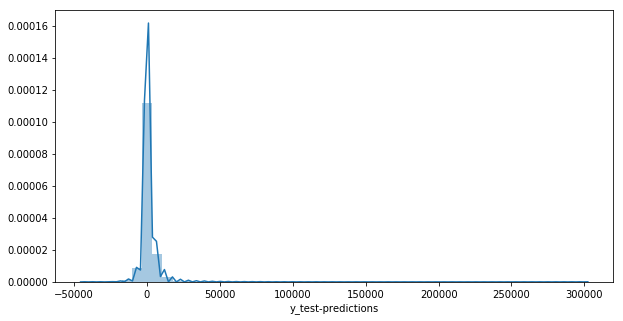

In [145]:
# Histograma de Residuos
# A maior parte dos erros parece aproximar-se de um valor proximo do zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test-predictions.flatten())
plt.xlabel("y_test-predictions")

## Validação Cruzada

In [52]:
# Utiliza-se o KerasRegressor porque é um problema de regressão

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_validate

### Criar o Modelo

In [159]:
### Criar o modelo de DNN numa função

def model():
    model = models.Sequential()
    model.add(layers.Dense(units=158, activation="relu", input_dim=316))
    model.add(layers.Dense(units=158, activation="relu"))
    model.add(layers.Dense(units=1, activation="linear"))
    model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_absolute_error"])
    
    return model

In [160]:
model = KerasRegressor(build_fn=model, epochs=2, batch_size=300)

### K-Fold Cross Validation

In [161]:
# cross validation
# scoring: neg_mean_absolute_error é igual ao mean_absolute_error. O calculo é igual apenas acresce o sinal negativo.

scores = cross_validate(estimator=model, X=X, y=y, cv=2, scoring="neg_mean_absolute_error", return_train_score=False)

Train on 179645 samples
Epoch 1/2
179645/179645 [==============================] - 1110s 6ms/sample - loss: 4140.5368 - mean_absolute_error: 4140.5381
Epoch 2/2
179645/179645 [==============================] - 4s 20us/sample - loss: 3551.9563 - mean_absolute_error: 3551.9561
Train on 179646 samples
Epoch 1/2
179646/179646 [==============================] - 976s 5ms/sample - loss: 4104.4488 - mean_absolute_error: 4104.4487
Epoch 2/2
179646/179646 [==============================] - 5s 25us/sample - loss: 3560.3169 - mean_absolute_error: 3560.3154


In [162]:
# Valores obtidos para o neg_mean_absolute_error atraves de cross validation
scores

{'fit_time': array([1524.37370777, 1326.32140946]),
 'score_time': array([102.32732487,  40.80586982]),
 'test_score': array([-3449.04991089, -3432.54420897])}

In [163]:
# neg_mean_absolute_error médio dos sub conjuntos de teste
np.mean(scores["test_score"])

-3440.7970599314913

In [164]:
# desvio padrão obtido atraves dos valores do neg_mean_absolute_error dos sub conjuntos de teste
# quanto maior este valor maior é a probabilidade do modelo não se ajustar bem ao conjunto de dados de teste.

np.std(scores["test_score"])

8.252850960927162

## Ajuste de parâmetros

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
# Criar o modelo de DNN numa função, com ajuste de parâmetros.

def model1(loss):
    model1 = models.Sequential()
    model1.add(layers.Dense(units=158, activation="relu", input_dim=316))
    model1.add(layers.Dense(units=158, activation="relu"))
    model1.add(layers.Dense(units=1, activation="linear"))
    model1.compile(optimizer="adam", loss=loss, metrics=["mean_absolute_error"])
    
    return model1

In [53]:
model1 = KerasRegressor(build_fn=model1, epochs=2, batch_size=300)

In [54]:
parametros = {'loss': ["mean_absolute_error", "mean_squared_error"]}

In [55]:
# Construção da grelha

grid = GridSearchCV(estimator=model1, param_grid=parametros, cv=3, refit=True)

In [56]:
# Ajustar o modelo com os parametros escolhidos e para o conjunto de dados total(a cross validation é feita pelo GridSearch).
grid.fit(X,y)

Train on 239527 samples
Epoch 1/2
239527/239527 [==============================] - 1228s 5ms/sample - loss: 4084.8104 - mean_absolute_error: 4084.8101
Epoch 2/2
239527/239527 [==============================] - 2s 9us/sample - loss: 3339.4742 - mean_absolute_error: 3339.4739
Train on 239527 samples
Epoch 1/2
239527/239527 [==============================] - 654s 3ms/sample - loss: 4073.6684 - mean_absolute_error: 4073.6680
Epoch 2/2
239527/239527 [==============================] - 2s 9us/sample - loss: 3376.3107 - mean_absolute_error: 3376.3115
Train on 239528 samples
Epoch 1/2
239528/239528 [==============================] - 1083s 5ms/sample - loss: 4056.8051 - mean_absolute_error: 4056.8044
Epoch 2/2
239528/239528 [==============================] - 2s 9us/sample - loss: 3389.0852 - mean_absolute_error: 3389.0835
Train on 239527 samples
Epoch 1/2
239527/239527 [==============================] - 206s 859us/sample - loss: 65628512.9374 - mean_absolute_error: 4320.1821
Epoch 2/2
239527/239

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000006D80001908>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['mean_absolute_error', 'mean_squared_error']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
# Os melhores parametros para o modelo
grid.best_params_

{'loss': 'mean_absolute_error'}